# Trying out an LSTM setup
## Using generated data
### Bi-directional LSTM with adversarial softmax layer

In [1]:
import numpy as np
import gym

def cart_pole(observation):
        
        position, velocity, angle, angle_velocity = observation
        action = int(3. * angle + angle_velocity > 0.)
        return action
        
def mountain_car(observation):

    position, velocity = observation
    lb = min(-0.09 * (position + 0.25) ** 2 + 0.03,
            0.3 * (position + 0.9) ** 4 - 0.008)
    ub = -0.07 * (position + 0.38) ** 2 + 0.07
    end = position > 0.2 and velocity > 0.02
    hard_end = position > 0.45
    begin = position < -0.45 and velocity < 0.001 and velocity > -0.001
    if begin or (lb < velocity < ub) or end or hard_end:
        action = 2 
    else:
        action = 0
    return action

class Expert(object):
        
    
    def __init__(self, env_name):
        
        policies = {
            'CartPole-v0': cart_pole,
            'MountainCar-v0': mountain_car
        }
        self.env_name = env_name
        self.env = gym.make(self.env_name)
        self.policy = policies[env_name]
        
    def generate_data(self, num_episodes=1):

        trajectories = []
        rewards = []
        
        for i in range(num_episodes):


            observation = self.env.reset()
            done = False
            rd = 0
            
            while not done:

                action = self.policy(observation)
                trajectories.append(
                    [
                        feature for feature in observation
                    ] + [action] + [i]
                )
                observation, reward, done, _ = self.env.step(action)
                rd += reward
            
            rewards.append(rd)
                
        return np.array(trajectories), np.mean(rewards)

### Generate data

In [2]:

expert = Expert('MountainCar-v0')
NUMBER_OF_EPISODES = 100
data, avg_reward = expert.generate_data(NUMBER_OF_EPISODES)
avg_reward

-102.64

In [3]:
data.shape

(10264, 4)

### Plot expert data

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

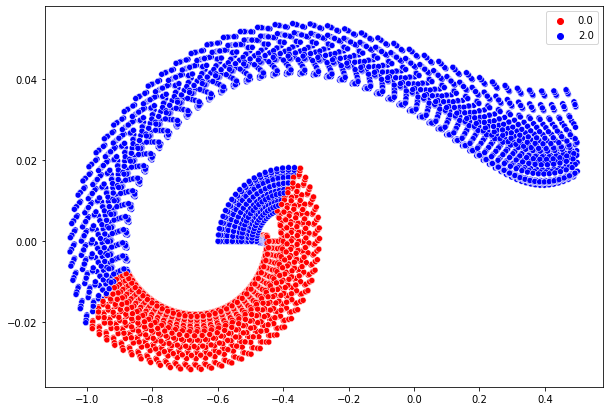

In [5]:
colors = np.array(['red', 'green', 'blue'])
palette = colors[np.unique(data[:,2]).astype(int)].tolist()

fig, ax = plt.subplots(figsize=(10, 7))
_ = sns.scatterplot(x=data[:,0], y=data[:,1], hue=data[:,2], palette=palette)

### Preprocess data into sequences

In [6]:
X_partitioned = np.empty((100,), dtype=object)
max_len = 0
for i in range(NUMBER_OF_EPISODES):
    
    seq = []
    length = 0
    for j in range(len(data)):
        
        if data[j][3] == i: 
            
            seq.append([x for x in data[j]])
            length +=1
    
    X_partitioned[i] = np.array(seq)
    if length > max_len: max_len = length
        
max_len

160

In [65]:
import torch
torch.cuda.CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda:0')

In [66]:
def seq_to_x(seq):
    
    return torch.tensor(
        [
            [seq[i][0], seq[i][1], int(i==0), int(i==len(seq)-1)] 
            for i in range(len(seq))
        ],
        dtype=torch.float
    ).to(device)

def seq_to_target(seq):
    
    return torch.tensor(
        [
            seq[i][2]  for i in range(len(seq))
        ],
        dtype=torch.long
    ).to(device)


def training_X(data):
    
    return [
                seq_to_x(seq) for seq in data
            ]

def training_Y(data):
    
    y = [seq_to_target(seq) for seq in data]
    return torch.cat(y)


def true_indicies(Y):
    
    true = []
    for i in range(Y.shape[0]):
        
        if Y[i] == 0 or Y[i] == 2:
            true.append(i)
    
    return true

In [58]:
X = training_X(X_partitioned)

In [67]:
Y = training_Y(X_partitioned).to(device)
Y.shape

torch.Size([10264])

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class PolicyLSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, target_size):
        
        super(PolicyLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, bias=True, batch_first=True, bidirectional=True)
        
        self.linear = nn.Linear(hidden_dim*2, target_size)
        
        self.output = nn.LogSoftmax(dim=1)
        
    def forward(self, batch):
        
        outputs = []
        for x in batch:
          
          out, hidden = self.lstm(x.unsqueeze(0))
          out = out.squeeze()
          outputs.append(torch.t(out))
        
        lstm_out = torch.t(torch.cat(outputs, dim=1))
        #print(lstm_out.shape)
        linear_out = self.linear(lstm_out)
        #print(linear_out.shape)
        out = self.output(linear_out)
        #print(out.shape)
        return out
    
    def predict(self, X):
        
        with torch.no_grad():
            pred = self.forward(X)
        
        return torch.argmax(pred, dim=1).view(-1)

model = PolicyLSTM(4, 10, 3).to(device)

In [69]:
def train(xdata, ydata, model, n_epochs, lr=0.01, print_every=100):
    '''Train the neural model with the given training data'''

    criterion = torch.nn.NLLLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01) 


    for epoch in range(n_epochs):
        
        model.zero_grad()
        
        Y_pred = model(xdata)
        
        #print(ydata[99])
        loss = criterion(Y_pred.view(-1, 3), ydata.view(-1))
        
        if epoch % print_every == 0: print('epoch: ', epoch,' loss: ', loss.item()) 

        loss.backward()

        optimizer.step()
        
    return model

In [79]:
train(X, Y, model, 5000, lr=0.001, print_every=100)

epoch:  0  loss:  1.164009928703308
epoch:  100  loss:  0.9385218620300293
epoch:  200  loss:  0.8377178311347961
epoch:  300  loss:  0.7831587791442871
epoch:  400  loss:  0.7495946884155273
epoch:  500  loss:  0.7270582318305969
epoch:  600  loss:  0.7109842896461487
epoch:  700  loss:  0.6989825963973999
epoch:  800  loss:  0.689670205116272
epoch:  900  loss:  0.6821938753128052
epoch:  1000  loss:  0.6760035157203674
epoch:  1100  loss:  0.670733630657196
epoch:  1200  loss:  0.6661331057548523
epoch:  1300  loss:  0.6620246767997742
epoch:  1400  loss:  0.6582803130149841
epoch:  1500  loss:  0.6548039317131042
epoch:  1600  loss:  0.6515222191810608
epoch:  1700  loss:  0.6483758687973022
epoch:  1800  loss:  0.6453150510787964
epoch:  1900  loss:  0.6422945261001587
epoch:  2000  loss:  0.6392688751220703
epoch:  2100  loss:  0.6361879110336304
epoch:  2200  loss:  0.6329898834228516
epoch:  2300  loss:  0.6295934915542603
epoch:  2400  loss:  0.6258882880210876
epoch:  2500  l

KeyboardInterrupt: ignored

In [76]:
preds = model.predict(X).cpu()
preds

tensor([1, 1, 1,  ..., 1, 1, 1])

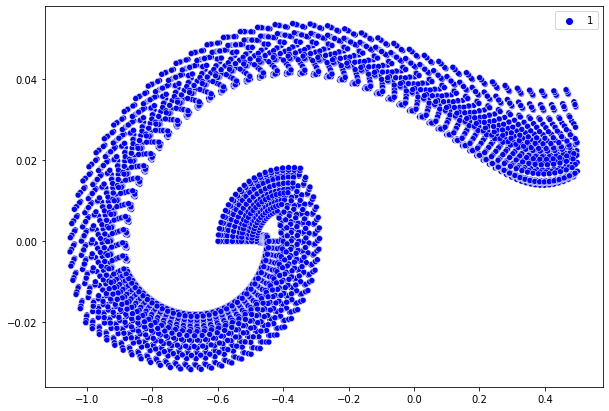

In [78]:
fig, ax = plt.subplots(figsize=(10,7))
_ = sns.scatterplot(x=data[:,0], y=data[:,1], hue=preds, palette=['blue'])

In [ ]:
env = gym.make('MountainCar-v0')
rewards = []


for i in range(10):

  print(i)
  observation = env.reset()
  done = False
  rd = 0
  is_first = 1
  traj = torch.unsqueeze(torch.tensor([[99, 99, 0, 1] for i in range(max_len)], dtype=torch.float), dim=0).to(device)
  while not done:
  
    # try:
    traj[0][-rd] = torch.tensor([ob for ob in observation] + [is_first] + [0], dtype=torch.float).to(device)
    action = model.predict(traj)
    observation, reward, done, _ = env.step(int(action[-rd].item()))
    rd += int(reward)
    if is_first == 1: is_first = 0
    # except IndexError as exe:
    #   rd = -200
    #   done = True

  rewards.append(rd)

np.mean(rewards)

0
1
2
3
4
5
6
7
8
9


-200.0